# Lab 4: Triangulation
You will find the complete lab manual in this file. Some exercises require written answers, while others require coding.

**Important:** Do **not** define functions directly in this notebook. Instead, save them in the `functions.py` file and call them from the code cells in this notebook.

### Submission Requirements:
Your final lab submission should include:
1. Your edited **notebook file** (`.ipynb`).
2. Your **`functions.py`** file containing all function definitions.
3. A **HTML printout** of the executed notebook with all outputs visible: File → Save and export Notebook As → HTML

First, we'll import a set of python packages you'll need for this lab.

In [1]:
# for creating responsive plots
%matplotlib widget  

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import scipy
import matplotlib.image as mpimg

## Task 1: Triangulation using Ransac
This whole lab is basically concerned with the camera equation
$$ \lambda u = PU $$
For the uncalibrated case, $u$ is a 3-vector with the homogeneous coordinates of a point in the image
$$ u = \begin{bmatrix}
x \\
y \\
1
\end{bmatrix}  $$
and $U$ is a 4-vector containing the homogeneous coordinates of the corresponding 3D point. 
The function `triangulation_test_case` is provided for creating a simple test case where you know the correct answer (`U_true`). Gaussian noise of standard deviation `sigma` is added to the image points. Use this example to verify your implemented functions in this lab.


In [2]:
from supplied import triangulation_test_case

sigma = 0.2
Ps, us, U_true = triangulation_test_case(sigma)
print(f"\nU_true:\n {U_true}")


U_true:
 [[0.81244442]
 [0.65870945]
 [0.84572361]]


### Task 1.1: 
Make a minimal solver for the triangulation problem, that is, a function `minimal_triangulation` that takes two camera matrices, `Ps`, and two image points, `us`, and triangulates a 3D point. The image points are in a 2 x 2 numpy array whereas the camera matrices are in a list containing two numpy arrays. Place the function in your `functions.py` file.

In [3]:
# def minimal_triangulation(Ps, us):
#     ...
#     return U

In [4]:
from functions import minimal_triangulation

U = minimal_triangulation(Ps, us)
print(f"\nU:\n {U}")


U:
 [0.81356112 0.65922282 0.85519217]


### Task 1.2:
Recall that $\lambda$ is the *depth*. Points with negative depth would lie behind the camera, so negative depths indicate that something is wrong. Make a function `check_depths` that takes $N$ camera matrices, `Ps`, and a 3D point, `U`, and checks the depth of `U` in each of the cameras. The output should be a an array of boolean values of length $N$ that indicates which depths were positive. Place it in your `functions.py` file.

In [5]:
# def check_depths(Ps, U):
#     ...
#     return positive

In [6]:
from functions import check_depths

positive = check_depths(Ps, U)
positive

array([1, 1])

### Task 1.3:
Make a function `reprojection_errors` that takes $N$ camera matrices, `Ps`, $N$ image points, `us`, and a 3D point, `U`, and computes a vector with the reprojection errors, that is, the lengths of the reprojection residuals. If a point has negative depth, set the reprojection error to `np.inf`. Place it in your `functions.py` file.

In [7]:
# def reprojection_errors(Ps, us, U):
#     ...
#     return errors

In [8]:
from functions import reprojection_errors

errors = reprojection_errors(Ps, us, U)
errors

array([0.11777857, 0.12661459])

### Task 1.4:
Make a function `ransac_triangulation` that implements triangulation using RANSAC. Use the number of outliers as loss function. A measurement is deemed as an outlier if the depth is negative or if the reprojection error is larger than `threshold`. Place it in your `functions.py` file. 

In [9]:
# def ransac_triangulation(Ps, us, threshold):
#     ...
#     return best_U, nbr_inliers

In [10]:
from functions import ransac_triangulation

threshold =  2
[U, nbr_inliers] = ransac_triangulation(Ps, us, threshold) 

print(f"U:\n {U}")
print(f"\nNumber inliers: {nbr_inliers}")

U:
 [0.81356112 0.65922282 0.85519217]

Number inliers: 2


### Task 1.5:
In `sequence.mat` you find an array `triangulation_examples` with triangulation examples. Each example (3D point) has a list of camera matrices `Ps` and a 2 x N-array `us` with image points. Run ransac_triangulation for all (or at least 5000) of the examples. Store all triangulated points with at least two inliers and plot them using `scatter`. There will always be a few outliers among the estimated 3D points that make it harder to view the plot. You can use the provided function `clean_for_plot` to clean it up a bit. 


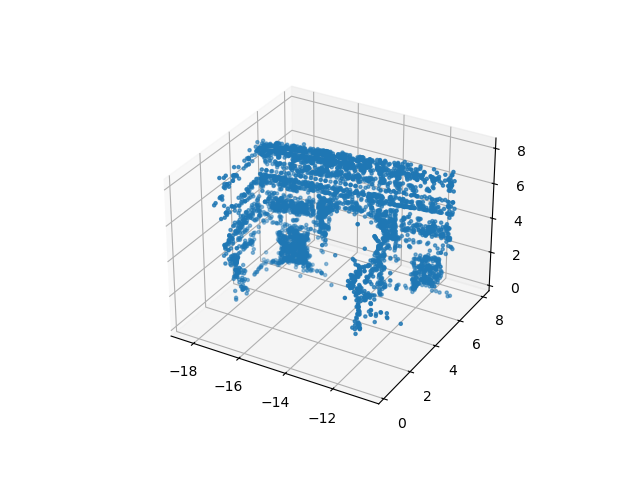

In [11]:
from supplied import clean_for_plot, equal_aspect_ratio

# Load data
data = scipy.io.loadmat('data/sequence.mat')

n_examples = 5000
points3D = data['triangulation_examples'][0][:n_examples]

threshold = 5
Us = np.zeros((3, n_examples))

for i in range(n_examples):
    example = points3D[i]
    Ps = [example['Ps'][0, j] for j in range(example['Ps'].shape[1])]
    xs = example['xs']

    # Your code here

    # RANSAC triangulation
    best_U, nbr_inliers = ransac_triangulation(Ps, xs, threshold)

    # Store triangulated points with at least two inliers
    if nbr_inliers >= 2:
        Us[:, i] = best_U

# Plot triangulated points
Uc, removed_indices = clean_for_plot(Us) 

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Uc[0, :], Uc[1, :], Uc[2, :], marker='.')

# Set axis equal for better scaling
equal_aspect_ratio(ax)
plt.show()

## Task 2: Least squares triangulation 
In this part of the lab you will solve the triangulation problem through least squares. Just as in the case of registration, the following pipeline is recommended: 
- Use RANSAC to obtain a rough estimate of the parameters ($U$). 
- Remove all measurements which are outliers with respect to these parameters. 
- Estimate the least squares parameters using the remaining measurements.

Note that in this case a *measurement* is a pair consisting of an image point $u_i$ and a camera matrix $P_i$. Don’t forget that points with negative depths should be outliers. 

### Task 2.1: 
Consider a camera matrix
$$ P_i = \begin{bmatrix}
\leftarrow a_i^T \rightarrow \\
\leftarrow b_i^T \rightarrow \\
\leftarrow c_i^T \rightarrow
\end{bmatrix} , $$
a 3D point $U$ and an image point $u_i$. Write the exact formula for the reprojection error $r_i(U)$ below.

**Your answer here:** <br>
The exact formula for the reprojection error $r_i(U)$ is:
$$ r_i(U) = \left\| \hat{u}_i - u_i \right\| = \left\| \begin{bmatrix} \hat{u}_{i_x} \\ \hat{u}_{i_y} \end{bmatrix} - \frac{1}{c_i^T U} \begin{bmatrix} a_i^T U \\ b_i^T U \end{bmatrix} \right\|$$
It can be derived as follows: <br>
Camera matrix $ P_i = \begin{bmatrix} a_i^T \\ b_i^T \\ c_i^T \end{bmatrix}$ <br>
3D point $ U = \begin{bmatrix} X \\ Y \\ Z \end{bmatrix}$ <br>
3D point in homogeneous coordinates $ U_{hom} = \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix}$ <br>
Projected 3D point $ p_i = P_i U_{hom} = \begin{bmatrix} a_i^T \\ b_i^T \\ c_i^T \end{bmatrix} \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} = \begin{bmatrix} a_i^T U \\ b_i^T U \\ c_i^T U \end{bmatrix} = \begin{bmatrix} p_{i_x} \\ p_{i_y} \\ p_{i_z} \end{bmatrix}$ <br>
Projected 2D point $ u_i = \frac{1}{p_{i_z}} \begin{bmatrix} p_{i_x} \\ p_{i_y} \end{bmatrix} = \frac{1}{c_i^T U} \begin{bmatrix} a_i^T U \\ b_i^T U \end{bmatrix}$ <br>
Measured 2D point $ \hat{u}_i = \begin{bmatrix} \hat{u}_{i_x} \\ \hat{u}_{i_y} \end{bmatrix}$

As you can see, the residuals are no longer linear, so computing a least squares solution will be significantly harder than in the previous lab. In fact, we cannot be sure to find the least squares solution. What we can do is to use local optimization to reduce the sum of squared residuals. We start at the solution produced by Ransac and use a few Gauss-Newton iterations.

### Task 2.2:
Make a function `compute_residuals` that takes an array `Ps` with $N$ cameras, a 2 x $N$ array `us` of image points and a 3 x 1 array `U`, and computes a 2$N$ x 1 array with all the reprojection residuals stacked into a single vector/array. A reprojection residual is a 2D vector corresponding to the difference between the original measurement and the projected point. The stacked vector is the $\bar{r}$ from the lecture notes (page 99). Place it in your `functions.py` file.

In [12]:
# def compute_residuals(Ps, us, U):
#     ...
#     return all_residuals

In [13]:
from functions import compute_residuals

# Usage example for one 3D point
index_point = 0
example = points3D[index_point]
Ps_example = [example['Ps'][0, j] for j in range(example['Ps'].shape[1])]
xs_example = example['xs']
U_example =  Us[:,index_point]

all_residuals = compute_residuals(Ps_example, xs_example, U_example)
all_residuals


array([ 10.82941287,   0.60982319,   3.71990062,  -0.23715326,
         1.47019204,   1.46345624,  -1.62482557,  -3.07950014,
        -0.15358831,  -1.62858873,  -3.71366076,   0.47712726,
         8.60055158, -21.79688534,  -0.68084934,  23.73995461,
        10.82941287,   0.60982319,   3.71990062,  -0.23715326,
         1.47019204,   1.46345624,  -1.62482557,  -3.07950014,
        -0.15358831,  -1.62858873,  -3.71366076,   0.47712726,
         8.60055158, -21.79688534,  -0.68084934,  23.73995461])

### Task 2.3:
Find formulas for the partial derivatives in the Jacobian of $\bar{r}$. The Jacobian should be a 2$N$ x 3- matrix. (Hint: you can start by finding the formula to the Jacobian of the i-th residual, which is a 2x3 matrix.) Please write down the exact formula and give a brief description about each variable that appears in the formula.   

**Your answer here:** <br>
As previously explained, the reprojection error can be expressed as follows:
$$ r_i(U) = \left\| \hat{u}_i - u_i \right\| = \left\| \begin{bmatrix} \hat{u}_{i_x} \\ \hat{u}_{i_y} \end{bmatrix} - \frac{1}{c_i^T U} \begin{bmatrix} a_i^T U \\ b_i^T U \end{bmatrix} \right\|$$
ThereFore, the Jacobian of the i-th residual is:
$$ J_i 
= \frac{\partial r_i(U)}{\partial U} 
= \begin{bmatrix} \frac{\partial r_{i_x}}{\partial U} \\ \frac{\partial r_{i_y}}{\partial U} \end{bmatrix}
= \begin{bmatrix} \frac{\partial }{\partial U}(\hat{u}_{i_x} - \frac{a_i^T U}{c_i^T U}) \\ \frac{\partial }{\partial U}(\hat{u}_{i_y} - \frac{b_i^T U}{c_i^T U}) \end{bmatrix}
= \begin{bmatrix} - \frac{a_i^T(c_i^T U)-(a_i^T U)c_i^T}{(c_i^T U)^2} \\ - \frac{b_i^T(c_i^T U)-(b_i^T U)c_i^T}{(c_i^T U)^2} \end{bmatrix}$$
Where, $ a_i^T $ , $ b_i^T$ and $ c_i^T $ are the rows of the camera matrix $ P_i = \begin{bmatrix} a_i^T \\ b_i^T \\ c_i^T \end{bmatrix}$, and $ U = \begin{bmatrix} X \\ Y \\ Z \end{bmatrix}$ is the 3D point. 

### Task 2.4: 
Make a function `compute_jacobian`, that computes the Jacobian given a 3 x 1- vector `U` and a cell array of camera matrices `Ps`. Place it in your `functions.py` file.

In [14]:
# def compute_jacobian(Ps, U):
#     ...
#     return jacobian

In [15]:
from functions import compute_jacobian

# Usage example
jacobian = compute_jacobian(Ps_example, U_example)
jacobian

array([[  16.77665751,  -72.95579775, -145.2213417 ],
       [ 159.8766768 ,   16.41694286,    7.41958708],
       [  23.69479334,  -74.00503723, -147.61521651],
       [ 161.40650701,   25.11258036,    9.72134077],
       [  27.94349036,  -69.91993945, -144.95004959],
       [ 157.53957901,   31.97012209,   10.90720158],
       [  28.74948492,  -68.29295165, -144.51590398],
       [ 155.40998033,   37.87240302,    8.79344576],
       [  29.37831644,  -68.88642273, -145.37877998],
       [ 155.3957103 ,   42.10203936,    7.30955285],
       [  34.06403675,  -70.2593811 , -147.416506  ],
       [ 156.57512201,   47.50574072,    9.50204   ],
       [  33.91228532,  -71.32366914, -147.31709897],
       [ 157.82500823,   49.63477836,    8.15033933],
       [  47.27401093,  -67.45669644, -148.31323007],
       [ 147.71802277,   77.4554208 ,    9.1310627 ],
       [  16.77665751,  -72.95579775, -145.2213417 ],
       [ 159.8766768 ,   16.41694286,    7.41958708],
       [  23.69479334,  -74.

### Task 2.5:
Use the functions `compute_residuals` och `compute_jacobian` to make a function `refine_triangulation` that uses an approximate 3D point `Uhat` as a starting point for Gauss-Newton’s method. Use five GaussNewton iterations. Print the sum of squared residuals after each Gauss-Newton step to verify that it decreases. Place it in your `functions.py` file.

In [16]:
# def refine_triangulation(Ps, us, Uhat, iterations=5):
#     ...    
#     return U_temp

In [17]:
from functions import refine_triangulation

# Usage example
Uref = refine_triangulation(Ps_example, xs_example, U_example)
Uref

array([-17.41310784,   3.82017515,   6.78419959])

### Task 2.6: 
Try your refine_triangulation on the data in `gauss_newton.mat`. First we will plot the points given in Uhat, then refine each point using your function and plot the results using `scatter3`. To see the improvement clearly, rotate the plot or use viewport angle `ax.view_init(elev=0, azim=-90)`. 

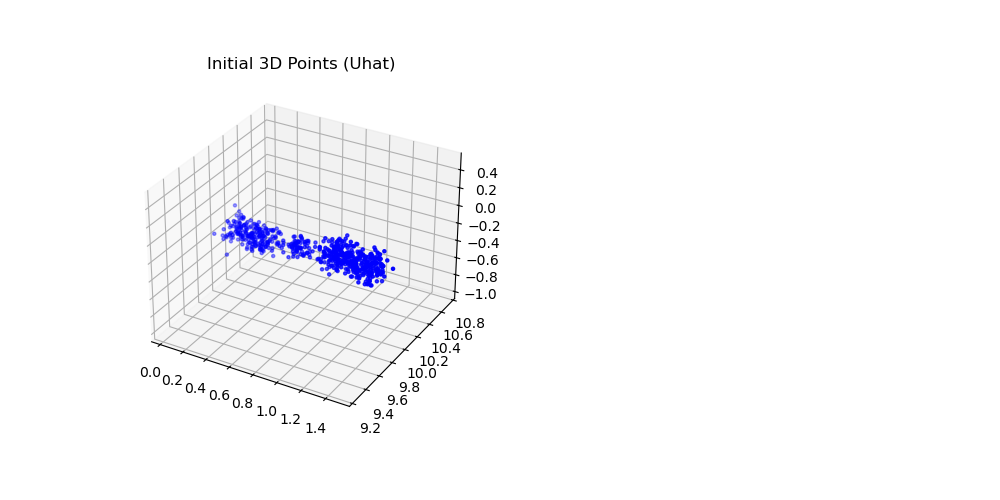

In [18]:
# Load data
data = scipy.io.loadmat('data/gauss_newton.mat')
Uhat = data['Uhat']        # 3xN
u = data['u']              # 2xN
u_tilde = data['u_tilde']  # 2xN
P = data['P']              # 3x4
P_tilde = data['P_tilde']  # 3x4

# Plot initial points
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(Uhat[0], Uhat[1], Uhat[2], c='blue', marker='.')
ax1.set_title('Initial 3D Points (Uhat)')
equal_aspect_ratio(ax1)

# Refine each point
N = Uhat.shape[1]
Uref = np.zeros((3, N))
Ps = [P, P_tilde]

for i in range(N):
    image_points = np.column_stack((u[:, i], u_tilde[:, i]))  # 2x2
    Uref[:, i] = refine_triangulation(Ps, image_points, Uhat[:, i])

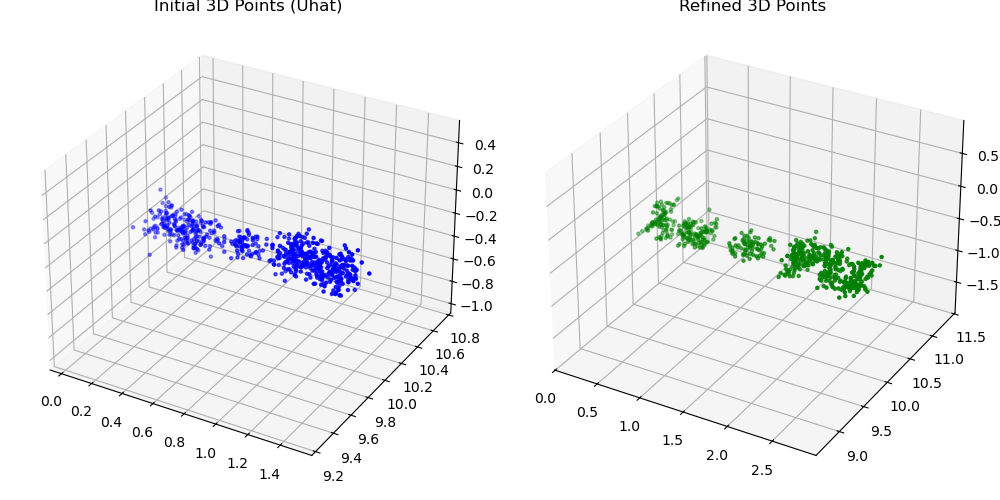

In [19]:
# Plot refined points
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(Uref[0], Uref[1], Uref[2], c='green', marker='.')
ax2.set_title('Refined 3D Points')

# Set axis equal for better scaling
equal_aspect_ratio(ax2)

plt.tight_layout()
plt.show()

### Task 2.7: 
Compute the camera positions for the data in `gauss_newton.mat` and plot them together with the estimated 3D points. Try to understand why the noise in the estimated points looks as it does. 

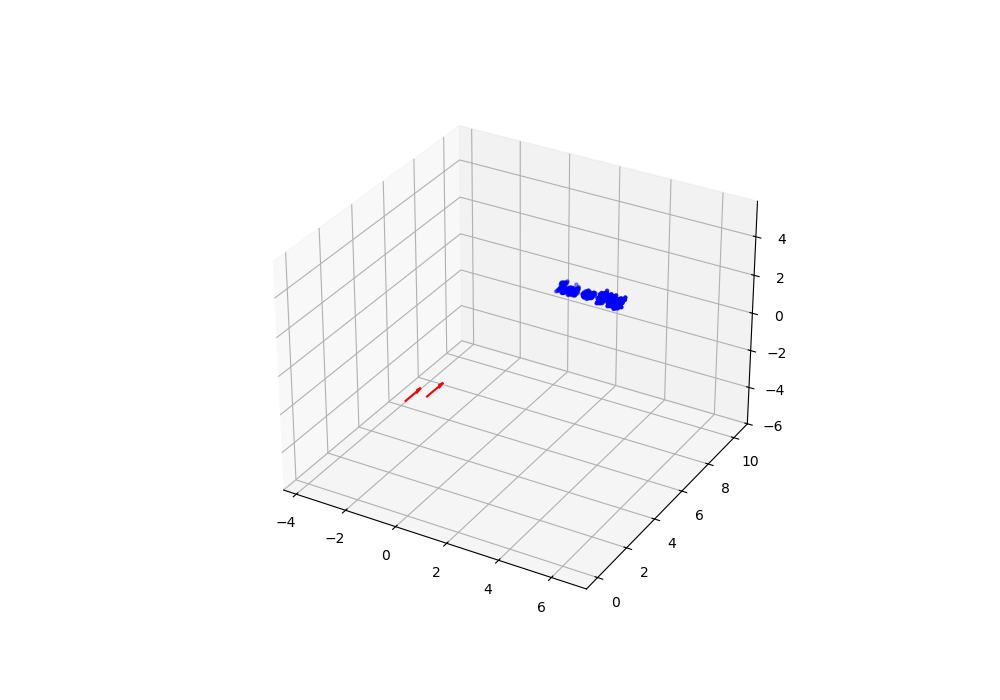

In [20]:
# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot refined 3D points (Uref)
ax.scatter(Uref[0], Uref[1], Uref[2], c='blue', marker='.')

# Compute camera positions, option 2
num_cams = len(Ps)
c = np.zeros((3, num_cams)) # was 4
v = np.zeros((3, num_cams))

# Your code here

for i in range(num_cams):
    P = Ps[i]  # Projection matrix (3x4)
    
    R = P[:, :3]
    t = P[:, 3]
    c[:,i] = -np.linalg.inv(R) @ t
    v[:, i] = R[2, :]
    
# Plot camera centers and viewing directions
ax.quiver(c[0, :], c[1, :], c[2, :],
        v[0, :], v[1, :], v[2, :],
        color='r', linewidth=1.5)

# Set axis equal for better scaling
equal_aspect_ratio(ax)

# Show plot
plt.show()


### Use of LLMS
- 1.1 understand np.linalg.svd to solve the homogeneous equation AX = 0 with SVD
- 2.2 np.concatenate(all_residuals).flatten() to stack the reprojection residuals into a single vector/array
- 2.5 difference between U_temp = Uhat and U_temp = Uhat.copy() and understand np.linalg.solve to solve Delta = - Step Gradient
